In [1]:
import sys
sys.path.insert(0, '../')

from interface import get_query_emb_batch, load_model, cosine_similarity_batch

from typing import Tuple, List, Dict, Union, Any

from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import torch

In [2]:
# pth_models = "/home/sondors/Documents/price/BERT_data/data/10-04-2024_Timofey/2801_models_Apple.csv"
pth_models = "/home/sondors/Documents/price/BERT_data/data/17-04-2024_Timofey/2801_offers_models_Apple.csv"
df_models = pd.read_csv(pth_models, sep=';')

pth_offers = '/home/sondors/Documents/price/BERT_data/data/17-04-2024_Timofey/2801_offers_test_Apple.csv'
df_offers = pd.read_csv(pth_offers, sep=';')

id_category = {
    # 3902: 'диктофоны, портативные рекордеры',
    # 510402: 'электронные книги',
    # 4302: 'автомобильные телевизоры, мониторы',
    # 2815: 'смарт-часы и браслеты',
    # 3901: 'портативные медиаплееры',
    # 3904: 'портативная акустика',
    2801: 'мобильные телефоны',
    # 3908: 'VR-гарнитуры (VR-очки, шлемы, очки виртуальной реальности, FPV очки для квадрокоптеров)',
    # 510401: 'планшетные компьютеры и мини-планшеты',
    # 2102: 'наушники, гарнитуры, наушники c микрофоном',
    # 3903: 'радиоприемники, радиобудильники, радиочасы',
    # 3907: 'магнитолы',
    # 280801: 'GPS-навигаторы'
    }

df_models = df_models[df_models['category_id'].isin(id_category.keys())].reset_index(drop=True)
df_offers = df_offers[df_offers['category_id'].isin(id_category.keys())].reset_index(drop=True)

models = list(df_models['full_name'])
offers = list(df_offers['name'])

df_offers

,name,model_id,offer_id,modelized_by_barcode,category_name,category_id,price,attrs,description,external_category,external_brand,external_type
0,"Смартфон Apple iPhone 11 128GB Черный ""Хорошее...",7883196,1870506860,False,мобильные телефоны,2801,29990.0,"[{'id': 3, 'type': 'e', 'value': 676.0}, {'id'...","Любовь с первого, второго, третьего, четвёртог...",Смартфоны с пробегом Б/У,Apple,Смартфон
1,Смартфон Apple iPhone 14 Pro Max 512Gb 6Gb тем...,7883608,1870801227,True,мобильные телефоны,2801,146389.0,"[{'id': 3, 'type': 'e', 'value': 676.0}, {'id'...",Смартфон Apple A2896 iPhone 14 Pro Max 512Gb 6...,"Ноутбуки, планшеты, смартфоны :: Смартфоны",Apple,Смартфон
2,Смартфон Apple iPhone 15 Pro 256 Гб Dual SIM т...,7883739,1876282775,True,мобильные телефоны,2801,135880.0,"[{'id': 3, 'type': 'e', 'value': 676.0}, {'id'...",Новый инновационный дизайн включает в себя зад...,Цифровая техника :: Смартфоны и мобильные теле...,Apple,Смартфон
3,Смартфон Apple iPhone 14 Plus 256GB eSim Yello...,7883485,1876136258,False,мобильные телефоны,2801,72790.0,"[{'id': 3, 'type': 'e', 'value': 676.0}, {'id'...",Смартфон Apple iPhone 14 Plus 256GB eSim Yello...,Смартфоны :: iPhone 14,Apple,Смартфон
4,Смартфон Apple iPhone 13 512GB Pink (розовый),7883348,1876413447,False,мобильные телефоны,2801,76990.0,"[{'id': 3, 'type': 'e', 'value': 676.0}, {'id'...",Смартфон Apple iPhone 13 512GB Pink (розовый) ...,Смартфоны :: iPhone 13,Apple,Смартфон
...,...,...,...,...,...,...,...,...,...,...,...,...
3351,Смартфон Apple iPhone 15 Pro Max 256Gb eSIM + ...,7883776,1873612511,False,мобильные телефоны,2801,149990.0,"[{'id': 3, 'type': 'e', 'value': 676.0}, {'id'...",Аппарат поддерживает 1 физическую SIM и eSIM. ...,Смартфоны :: Apple,Apple,Смартфон
3352,Смартфон Apple iPhone 15 Pro Max 256Gb eSIM on...,7883766,1873611822,False,мобильные телефоны,2801,149990.0,"[{'id': 3, 'type': 'e', 'value': 676.0}, {'id'...","Аппарат не поддерживает физические SIM, только...",Смартфоны :: Apple,Apple,Смартфон
3353,Смартфон Apple iPhone 15 Pro 256Gb eSIM + SIM ...,7883739,1873611850,False,мобильные телефоны,2801,135990.0,"[{'id': 3, 'type': 'e', 'value': 676.0}, {'id'...",Аппарат поддерживает 1 физическую SIM и eSIM. ...,Смартфоны :: Apple,Apple,Смартфон
3354,"Смартфон Apple iPhone 15 Pro 512 ГБ, Dual eSIM...",7883743,1878760256,True,мобильные телефоны,2801,114990.0,"[{'id': 3, 'type': 'e', 'value': 676.0}, {'id'...",Цвет: Синий титан | Автофокус: Да | Диагональ ...,Смартфоны :: iPhone :: iPhone 15 Pro,NaN,NaN


In [3]:
df_models

,model_id,average_price,name,brand_name,full_name,comment,category_name,category_id,offer_id
0,7883190,45490.0,"iPhone 11 128Gb, Dual nano-SIM, Черный",Apple,"Apple iPhone 11 128Gb, Dual nano-SIM, Черный",NaN,мобильные телефоны,2801,NaN
1,7883191,35999.0,"iPhone 11 128Gb, nano-Sim+eSIM, Green",Apple,"Apple iPhone 11 128Gb, nano-Sim+eSIM, Green",NaN,мобильные телефоны,2801,NaN
2,7883192,53998.5,"iPhone 11 128Gb, nano-Sim+eSIM, Белый",Apple,"Apple iPhone 11 128Gb, nano-Sim+eSIM, Белый",NaN,мобильные телефоны,2801,NaN
3,7883193,48490.0,"iPhone 11 128Gb, nano-Sim+eSIM, Желтый",Apple,"Apple iPhone 11 128Gb, nano-Sim+eSIM, Желтый",NaN,мобильные телефоны,2801,NaN
4,7883194,31990.0,"iPhone 11 128Gb, nano-Sim+eSIM, Красный",Apple,"Apple iPhone 11 128Gb, nano-Sim+eSIM, Красный",NaN,мобильные телефоны,2801,NaN
...,...,...,...,...,...,...,...,...,...
3888,7924771,NaN,NaN,NaN,"Смартфон iPhone 7 Plus 32 GB Silver (), состоя...",NaN,мобильные телефоны,2801,1.745309e+09
3889,7924772,NaN,NaN,NaN,"Смартфон iPhone 8 Plus 256 GB Space Gray (), с...",NaN,мобильные телефоны,2801,1.745313e+09
3890,7924773,NaN,NaN,NaN,"Смартфон iPhone 8 Plus 64 GB Silver (), состоя...",NaN,мобильные телефоны,2801,1.745305e+09
3891,7924774,NaN,NaN,NaN,"Смартфон iPhone 8 Plus 64 GB Space Gray (), со...",NaN,мобильные телефоны,2801,1.745313e+09


In [4]:
# ckpt_pth = "/home/sondors/Documents/ColBERT_weights/triples_X1_13_categories_use_ib_negatives/none/2024-01/26/10.49.44/checkpoints/colbert-5387-finish"
# experiment = "colbert-5387"

ckpt_pth = "/home/sondors/Documents/ColBERT_weights/2801_lr04_bsize_210_apple/none/2024-04/18/09.16.10/checkpoints/colbert-187-finish"
experiment = "colbert-187-finish"

doc_maxlen = 300
nbits = 2   # bits определяет количество битов у каждого измерения в семантическом пространстве во время индексации
nranks = 1  # nranks определяет количество GPU для использования, если они доступны
kmeans_niters = 4 # kmeans_niters указывает количество итераций k-means кластеризации; 4 — хороший и быстрый вариант по умолчанию. 

device = "cuda"


In [5]:
checkpoint = load_model(ckpt_pth, doc_maxlen, nbits, kmeans_niters, device)

In [6]:
offer_embs = get_query_emb_batch(offers, checkpoint, batch_size=1000, batch_size2=10000)

batch: 3356/3356


In [7]:
len(offers)

3356

In [8]:
model_embs = get_query_emb_batch(models, checkpoint, batch_size=1000, batch_size2=10000)


batch: 3893/3893


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

import torch.optim as optim
from torch.utils.data import DataLoader
import time

class Encoder(nn.Module):
    def __init__(self, input_dim=(32, 768), latent_dim=128):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim[0] * input_dim[1], 1024)  # Flatten input
        self.fc2 = nn.Linear(1024, 256)
        self.fc31 = nn.Linear(256, latent_dim)
        self.fc32 = nn.Linear(256, latent_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the matrix to a vector
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)

class Decoder(nn.Module):
    def __init__(self, latent_dim=128, output_dim=(32, 768)):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 1024)
        self.fc3 = nn.Linear(1024, output_dim[0] * output_dim[1])
        self.output_dim = output_dim

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        return torch.sigmoid(self.fc3(h)).view(-1, self.output_dim[0], self.output_dim[1])  # Reshape to original

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

class SiameseNetwork(nn.Module):
    def __init__(self, latent_dim=128):
        super(SiameseNetwork, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, z1, z2):
        h1 = F.relu(self.fc1(z1))
        h2 = F.relu(self.fc1(z2))
        diff = torch.abs(h1 - h2)
        out = F.relu(self.fc2(diff))
        return torch.sigmoid(self.fc3(out)).squeeze(1)  # Ensure this line produces a shape of [batch_size]

def emb_to_df(df, embs, imya_kategorii):
    df = df[df.category_name == imya_kategorii]
    embed_name = []
    for index, row in df.iterrows():
        embed_name.append(embs[index])
    return embed_name

def top_n_to_df(df, indices, top_n, n):
    for idx, insert_dict in zip(indices, top_n):
        for i in range(n):
            col_model_id = f'model_id_pred_{i+1}'
            col_similarity = f'cosine_sims_{i+1}'
            df.loc[idx, col_model_id] = insert_dict['model_ids'][i]
            df.loc[idx, col_similarity] = round(float(insert_dict['cosine_sims'][i]), 5)
    return df

def inference_category_siam(vae, siamese, df_offers, df_models, imya_kategorii, models_embs, offers_embs):
    print(f"{imya_kategorii}")
    start_time = time.time()
    df_models = df_models[df_models.category_name == imya_kategorii]

    offer_embs = emb_to_df(df_offers, offers_embs, imya_kategorii)

    model_embs = emb_to_df(df_models, models_embs, imya_kategorii)
    model_model_id = list(df_models['model_id'])

    print(f"\tофферов {len(offer_embs)} шт поиск матча для каждого среди {len(model_model_id)} шт моделей")

    top_n = top_n_similar_MLP(offer_embs, model_embs, model_model_id, vae, siamese, n=5, batch_size=3893)
    # offer_model_id_predicted = [i['model_ids'][0] for i in top_n]
    # cos_sims = [i['cosine_sims'][0] for i in top_n]
    indices = tuple(df_offers.index)
    df_offers = top_n_to_df(df_offers, indices, top_n, 5)
    print(f"time_spent = {round(time.time() - start_time, 2)} sec\n")
    return df_offers

from torch.utils.data import DataLoader, TensorDataset

def top_n_similar_MLP(offer_embs: List[np.ndarray], model_embs: List[np.ndarray], model_ids: List[int], vae: nn.Module, siamese: nn.Module, n: int = 5, batch_size: int = 64) -> List[Dict[str, Union[List[int], np.ndarray]]]:
    """
    Find the top N similar embeddings for each offer embedding using a VAE and Siamese network model.

    Args:
        offer_embs (List[np.ndarray]): List of offer embeddings.
        vae (nn.Module): Trained VAE model.
        siamese (nn.Module): Trained Siamese network model.
        model_embs (List[np.ndarray]): List of model embeddings.
        model_ids (List[int]): List of model IDs corresponding to model embeddings.
        n (int, optional): Number of top similar embeddings to retrieve. Defaults to 5.
        batch_size (int, optional): Batch size for processing model embeddings. Defaults to 64.

    Returns:
        List[Dict[str, Union[List[int], np.ndarray]]]: A list of dictionaries containing model IDs and their 
        corresponding cosine similarity scores for the top N similar embeddings for each offer embedding.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae.to(device)
    siamese.to(device)

    # Create DataLoader for model embeddings
    model_embs_tensor = torch.tensor(model_embs, dtype=torch.float32)
    model_dataset = TensorDataset(model_embs_tensor)
    model_loader = DataLoader(model_dataset, batch_size=batch_size, shuffle=False)

    top_n_list = []
    with torch.no_grad():
        for i, offer_emb in enumerate(offer_embs):
            offer_emb_tensor = torch.tensor(offer_emb, dtype=torch.float32).to(device).unsqueeze(0)
            mu, log_var = vae.encoder(offer_emb_tensor)
            offer_latent = vae.reparameterize(mu, log_var)

            model_outputs = []
            for model_batch in model_loader:
                model_emb_batch = model_batch[0].to(device)
                mu_batch, log_var_batch = vae.encoder(model_emb_batch)
                model_latent_batch = vae.reparameterize(mu_batch, log_var_batch)

                batch_size_actual = model_latent_batch.size(0)
                offer_latent_expanded = offer_latent.expand(batch_size_actual, -1)
                batch_output = siamese(offer_latent_expanded, model_latent_batch)
                model_outputs.append(batch_output)

            model_outputs = torch.cat(model_outputs, dim=0)
            cosine_sims = model_outputs.squeeze().cpu().numpy()
            top_n_indices = np.argsort(cosine_sims)[::-1][:n]
            top_n_model_ids = [model_ids[i] for i in top_n_indices]
            top_n_cosine_sims = cosine_sims[top_n_indices]
            top_n_list.append({"model_ids": top_n_model_ids, "cosine_sims": top_n_cosine_sims})

    return top_n_list

model_vae = VAE()
model_vae.load_state_dict(torch.load('/home/sondors/Documents/price/ColBERT/vae_epoch_20.pth'))
model_vae.eval()

model_siamese = SiameseNetwork()
model_siamese.load_state_dict(torch.load('/home/sondors/Documents/price/ColBERT/siamese_epoch_20.pth'))
model_siamese.eval()

for category in id_category.values():
    df_offers_MLP = inference_category_siam(model_vae, model_siamese, df_offers, df_models, category, model_embs, offer_embs)


мобильные телефоны
	офферов 3356 шт поиск матча для каждого среди 3893 шт моделей
time_spent = 1089.89 sec



In [13]:
df_offers_MLP

,name,model_id,offer_id,modelized_by_barcode,category_name,category_id,price,attrs,description,external_category,...,model_id_pred_1,cosine_sims_1,model_id_pred_2,cosine_sims_2,model_id_pred_3,cosine_sims_3,model_id_pred_4,cosine_sims_4,model_id_pred_5,cosine_sims_5
0,"Смартфон Apple iPhone 11 128GB Черный ""Хорошее...",7883196,1870506860,False,мобильные телефоны,2801,29990.0,"[{'id': 3, 'type': 'e', 'value': 676.0}, {'id'...","Любовь с первого, второго, третьего, четвёртог...",Смартфоны с пробегом Б/У,...,7883196.0,0.99917,7883196.0,0.99830,7883190.0,0.99763,7883196.0,0.99688,7883196.0,0.99652
1,Смартфон Apple iPhone 14 Pro Max 512Gb 6Gb тем...,7883608,1870801227,True,мобильные телефоны,2801,146389.0,"[{'id': 3, 'type': 'e', 'value': 676.0}, {'id'...",Смартфон Apple A2896 iPhone 14 Pro Max 512Gb 6...,"Ноутбуки, планшеты, смартфоны :: Смартфоны",...,7883604.0,0.99912,7883612.0,0.99738,7883612.0,0.99653,7883604.0,0.99557,7883612.0,0.99538
2,Смартфон Apple iPhone 15 Pro 256 Гб Dual SIM т...,7883739,1876282775,True,мобильные телефоны,2801,135880.0,"[{'id': 3, 'type': 'e', 'value': 676.0}, {'id'...",Новый инновационный дизайн включает в себя зад...,Цифровая техника :: Смартфоны и мобильные теле...,...,7883733.0,0.94930,7883717.0,0.93476,7883738.0,0.88985,7883734.0,0.87620,7883738.0,0.86209
3,Смартфон Apple iPhone 14 Plus 256GB eSim Yello...,7883485,1876136258,False,мобильные телефоны,2801,72790.0,"[{'id': 3, 'type': 'e', 'value': 676.0}, {'id'...",Смартфон Apple iPhone 14 Plus 256GB eSim Yello...,Смартфоны :: iPhone 14,...,7883485.0,0.99993,7883485.0,0.99908,7883497.0,0.99831,7883491.0,0.99759,7883497.0,0.99654
4,Смартфон Apple iPhone 13 512GB Pink (розовый),7883348,1876413447,False,мобильные телефоны,2801,76990.0,"[{'id': 3, 'type': 'e', 'value': 676.0}, {'id'...",Смартфон Apple iPhone 13 512GB Pink (розовый) ...,Смартфоны :: iPhone 13,...,7883348.0,0.99241,7883348.0,0.99133,7883348.0,0.98748,7883348.0,0.97469,7883348.0,0.96187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3351,Смартфон Apple iPhone 15 Pro Max 256Gb eSIM + ...,7883776,1873612511,False,мобильные телефоны,2801,149990.0,"[{'id': 3, 'type': 'e', 'value': 676.0}, {'id'...",Аппарат поддерживает 1 физическую SIM и eSIM. ...,Смартфоны :: Apple,...,7883776.0,0.99918,7883772.0,0.99911,7883768.0,0.99890,7883776.0,0.99880,7883768.0,0.99767
3352,Смартфон Apple iPhone 15 Pro Max 256Gb eSIM on...,7883766,1873611822,False,мобильные телефоны,2801,149990.0,"[{'id': 3, 'type': 'e', 'value': 676.0}, {'id'...","Аппарат не поддерживает физические SIM, только...",Смартфоны :: Apple,...,7883774.0,0.99999,7883770.0,0.99995,7883766.0,0.99989,7883766.0,0.99978,7883766.0,0.99976
3353,Смартфон Apple iPhone 15 Pro 256Gb eSIM + SIM ...,7883739,1873611850,False,мобильные телефоны,2801,135990.0,"[{'id': 3, 'type': 'e', 'value': 676.0}, {'id'...",Аппарат поддерживает 1 физическую SIM и eSIM. ...,Смартфоны :: Apple,...,7883731.0,0.92931,7883735.0,0.91103,7883731.0,0.91088,7883735.0,0.88503,7883731.0,0.85547
3354,"Смартфон Apple iPhone 15 Pro 512 ГБ, Dual eSIM...",7883743,1878760256,True,мобильные телефоны,2801,114990.0,"[{'id': 3, 'type': 'e', 'value': 676.0}, {'id'...",Цвет: Синий титан | Автофокус: Да | Диагональ ...,Смартфоны :: iPhone :: iPhone 15 Pro,...,7883751.0,0.99820,7883751.0,0.99709,7883751.0,0.99392,7883743.0,0.99213,7883747.0,0.99001


In [14]:
dict(df_offers_MLP.iloc[0])

{'name': 'Смартфон Apple iPhone 11 128GB Черный "Хорошее состояние"',
 'model_id': 7883196,
 'offer_id': 1870506860,
 'modelized_by_barcode': False,
 'category_name': 'мобильные телефоны',
 'category_id': 2801,
 'price': 29990.0,
 'attrs': "[{'id': 3, 'type': 'e', 'value': 676.0}, {'id': 1626, 'type': 'r', 'value': 6.1}, {'id': 3087, 'type': 'b', 'value': 1.0}, {'id': 14517, 'type': 'b', 'value': 1.0}, {'id': 23613, 'type': 'e', 'value': 65445.0}, {'id': 23626, 'type': 'b', 'value': 1.0}, {'id': 25534, 'type': 'e', 'value': 716.0}, {'id': 25586, 'type': 'e', 'value': 733.0}, {'id': 25597, 'type': 'e', 'value': 745.0}]",
 'description': 'Любовь с первого, второго, третьего, четвёртого, пятого, шестого взгляда Дисплей Liquid Retina 6,1 дюйма &ndash; на всю переднюю панель и с невероятной цветопередачей. Плохое фото? Не выйдет Новая система двух камер. Можно делать фотоснимки с широким и сверхшироким углом обзора. Обновлённый интерфейс и новая сверхширокоугольная камера позволят увидеть и

In [15]:
# df_offers_MLP.to_csv("/home/sondors/Documents/price/ColBERT/EVAL/offers_top_n_Apple_test_MLP.csv", sep=';',index=False)


In [16]:
import matplotlib.pyplot as plt
import numpy as np

def thresholds_accuracies_part(thresholds, accuracies, part, x_start=0, x_stop=1.001, x_step=0.025):
    """
    Визуализирует зависимость точности и части от общего числа строк 
    от порога cosine_sims_1 на двух подграфиках.

    Параметры:
    - thresholds: список порогов cosine_sims_1
    - accuracies: список значений точности
    - part: список значений части от общего числа строк
    - x_start: начальное значение по оси X
    """
    filtered_thresholds = [t for t in thresholds if t >= x_start]
    filtered_accuracies = accuracies[len(thresholds) - len(filtered_thresholds):]
    filtered_part = part[len(thresholds) - len(filtered_thresholds):]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.plot(filtered_thresholds, filtered_accuracies, marker='.', label='Accuracy')
    ax1.set_title('Зависимость точности от порога cosine_sims_1')
    ax1.set_xlabel('Порог cosine_sims_1')
    ax1.set_ylabel('Accuracy')
    ax1.grid(True)

    ax1.set_xticks(np.arange(x_start, x_stop, x_step))

    # Построение второго графика (часть от общего числа строк)
    ax2.plot(filtered_thresholds, filtered_part, marker='.', color='orange', linestyle='dashed', label='Часть от общего числа строк')
    ax2.set_title('Зависимость части от общего числа строк от порога cosine_sims_1')
    ax2.set_xlabel('Порог cosine_sims_1')
    ax2.set_ylabel('Часть от общего числа строк')
    ax2.grid(True)

    ax2.set_xticks(np.arange(x_start, x_stop, x_step))

    plt.tight_layout()
    plt.show()

def accuracies_part(accuracies, part, x_start=0, x_stop=1.001, x_step=0.025):
    """
    Визуализирует зависимость точности и части от общего числа строк 
    на одном графике.

    Параметры:
    - accuracies: список значений точности
    - part: список значений части от общего числа строк
    """
    filtered_accuracies = [t for t in accuracies if t >= x_start]
    filtered_part = part[len(part) - len(filtered_accuracies):]
    plt.figure(figsize=(8, 6))

    plt.plot(filtered_accuracies, filtered_part, marker='.', color='orange', linestyle='dashed', label='Accuracy vs. Part')
    plt.title('Зависимость точности от части от общего числа строк')
    plt.xlabel('Accuracy')
    plt.ylabel('Часть от общего числа строк')
    plt.grid(True)

    plt.xticks(np.arange(x_start, x_stop, x_step))

    plt.tight_layout()
    plt.show()

def plot_threshold_accuracies(thresholds, accuracies, x_start=0, x_stop=1.001, x_step=0.025, y_step=0.01):
    """
    Визуализирует зависимость точности от порога cosine_sims_1.

    Параметры:
    - thresholds: список порогов cosine_sims_1
    - accuracies: список значений точности
    - x_start: начальное значение по оси X
    """
    filtered_thresholds = [t for t in thresholds if t >= x_start]
    filtered_accuracies = accuracies[len(thresholds) - len(filtered_thresholds):]

    plt.figure(figsize=(8, 6))

    plt.plot(filtered_thresholds, filtered_accuracies, marker='.', label='Accuracy')
    plt.title('Зависимость точности от порога cosine_sims_1')
    plt.xlabel('Порог cosine_sims_1')
    plt.ylabel('Accuracy')
    plt.grid(True)

    plt.yticks(np.arange(min(filtered_accuracies), max(filtered_accuracies), y_step))

    plt.xticks(np.arange(x_start, x_stop, x_step))

    plt.tight_layout()
    plt.show()

def plot_threshold_part(thresholds, part, x_start=0, x_stop=1.001, x_step=0.025):
    """
    Визуализирует зависимость части от общего числа строк от порога cosine_sims_1.

    Параметры:
    - thresholds: список порогов cosine_sims_1
    - part: список значений части от общего числа строк
    - x_start: начальное значение по оси X
    """
    filtered_thresholds = [t for t in thresholds if t >= x_start]
    filtered_part = part[len(thresholds) - len(filtered_thresholds):]

    plt.figure(figsize=(8, 6))

    plt.plot(filtered_thresholds, filtered_part, marker='.', color='orange', linestyle='dashed', label='Часть от общего числа строк')
    plt.title('Зависимость части от общего числа строк от порога cosine_sims_1')
    plt.xlabel('Порог cosine_sims_1')
    plt.ylabel('Часть от общего числа строк')
    plt.grid(True)

    plt.xticks(np.arange(x_start, x_stop, x_step))

    plt.tight_layout()
    plt.show()

# Подсчет accuracy в зависимости от порога cosine_sims_1
thresholds = [i/1000 for i in range(1000)]
accuracies = []
part = []
for threshold in thresholds:
    df_thersold = df_offers_MLP[df_offers_MLP['cosine_sims_1'] >= threshold]
    accurate_predictions_threshold = (df_thersold['model_id_pred_1'].astype(int) == df_thersold['model_id']).sum()
    accuracy = accurate_predictions_threshold / len(df_thersold)
    accuracies.append(accuracy)
    # part.append(len(df_thersold)/len(df))
    part.append(len(df_thersold))

# Вывод результатов
# for threshold, accuracy in zip(thresholds, accuracies):
#     print(f"Порог cosine_sims_1: {threshold}, Accuracy: {accuracy}")

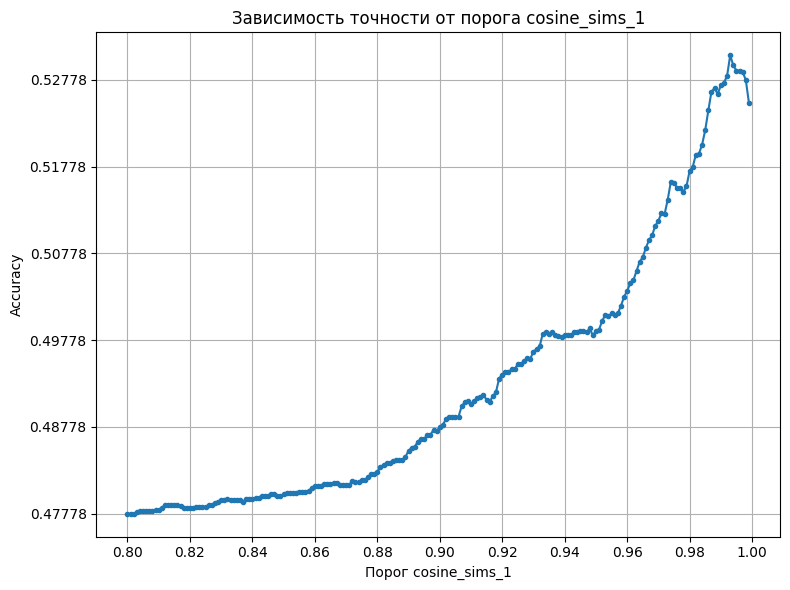

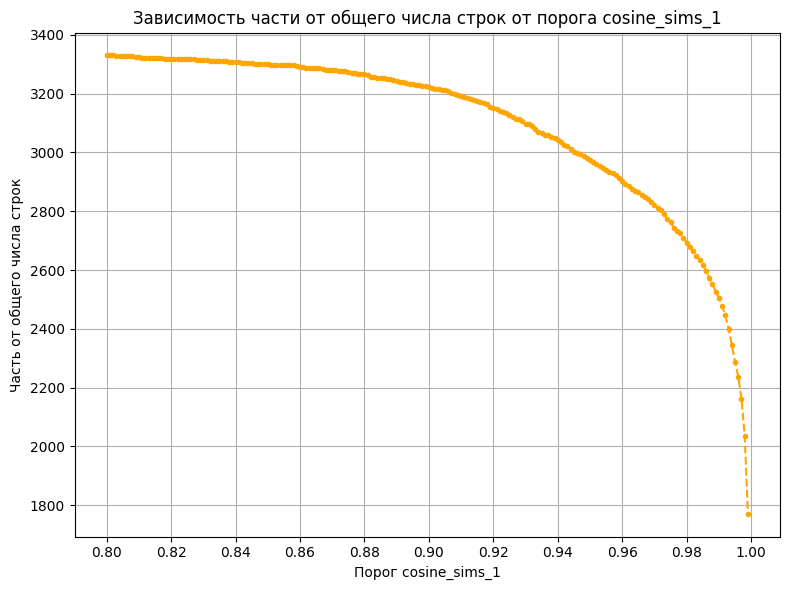

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:28                                                                                   │
│                                                                                                  │
│   25                                                                                             │
│   26 plot_threshold_accuracies(thresholds, accuracies, x_start=0.8, x_stop=1.001, x_step=0.02    │
│   27 plot_threshold_part(thresholds, part, x_start=0.8, x_stop=1.001, x_step=0.02)               │
│ ❱ 28 accuracies_part(accuracies, [i/len(df_offers) for i in part], x_start=0.8, x_stop=1.001,    │
│   29                                                                                             │
│                                                                                                  │
│ in accuracies_part:20                                                                            │
│                                                                                                  │
│   17 │   plt.ylabel('Часть от общего числа строк')                                               │
│   18 │   plt.grid(True)                                                                          │
│   19 │                                                                                           │
│ ❱ 20 │   plt.yticks(np.arange(min(filtered_part), max(filtered_part), 0.05))                     │
│   21 │   plt.xticks(np.arange(x_start, x_stop, x_step))                                          │
│   22 │                                                                                           │
│   23 │   plt.tight_layout()                                                                      │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: min() arg is an empty sequence

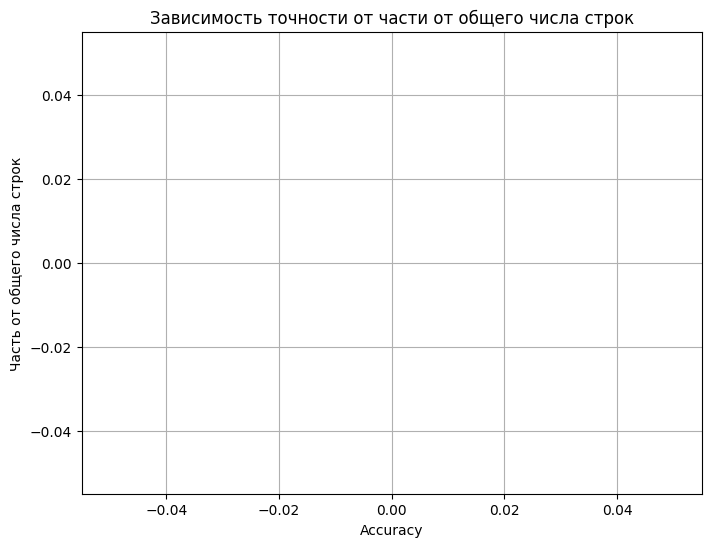

In [17]:
def accuracies_part(accuracies, part, x_start=0, x_stop=1.001, x_step=0.025):
    """
    Визуализирует зависимость точности и части от общего числа строк 
    на одном графике.

    Параметры:
    - accuracies: список значений точности
    - part: список значений части от общего числа строк
    """
    filtered_accuracies = [t for t in accuracies if t >= x_start]
    filtered_part = part[len(part) - len(filtered_accuracies):]
    plt.figure(figsize=(8, 6))

    plt.plot(filtered_accuracies, filtered_part, marker='.', color='orange', linestyle='dashed', label='Accuracy vs. Part')
    plt.title('Зависимость точности от части от общего числа строк')
    plt.xlabel('Accuracy')
    plt.ylabel('Часть от общего числа строк')
    plt.grid(True)

    plt.yticks(np.arange(min(filtered_part), max(filtered_part), 0.05))
    plt.xticks(np.arange(x_start, x_stop, x_step))

    plt.tight_layout()
    plt.show()

plot_threshold_accuracies(thresholds, accuracies, x_start=0.8, x_stop=1.001, x_step=0.02, y_step=0.01)
plot_threshold_part(thresholds, part, x_start=0.8, x_stop=1.001, x_step=0.02)
accuracies_part(accuracies, [i/len(df_offers) for i in part], x_start=0.8, x_stop=1.001, x_step=0.02)